In [9]:
from asammdf import MDF
import easygui
import pandas as pd
import glob, os
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import binned_statistic_2d 

def graph(x):
    xtick = [108,216,324,432,540,648,756]
    graph_ = x.plot(kind='line',figsize=(10, 6), rot=90,xticks=xtick,grid=True,legend=True) 
    plt.grid(linestyle='dotted')
    plt.xlabel('time(s)')
    plt.ylabel('mg')
    plt.title(x.name+" Modal")
    

def readModal(folder, baseName):
    filePath = os.path.join(folder, baseName)
    xlsFile = pd.ExcelFile(filePath)
    dfModal = xlsFile.parse('Data')
    return dfModal

def determineShift(x, y):
    """
    Returns the value by which y should be shifted to left
    """
    assert len(x) == len(y)
    corr = np.correlate(x, y, "full")
    zeroIndex = len(x) - 1
    print(np.argmax(corr))
    print(zeroIndex)
    return zeroIndex - np.argmax(corr)

def heatMap(x, y, z, xbins, ybins, title = "", 
            method = "count", scatterXlabel = "RPM[rpm]", 
            scatterYlabel = "Exhaust Temperature[C]", cmap = "YlGnBu", **kwargs):
    """
    This function bins the values according to method. It also plots the graph.
    It returns the dataframe
    """
    binplot, xedges, yedges, binIndex = binned_statistic_2d(x, y, z, statistic= method, bins=(xbins,ybins))
    binplot[np.isnan(binplot)] = 0
    #normalising
    if method == "count":
        binplot = binplot/np.cumsum(binplot)[-1]*100
        print(np.sum(binplot))
    binplot = binplot.T
    binplot = binplot[::-1]
    xmid = list(zip(xedges[:-1], xedges[1:]))
    ymid = list(zip(yedges[:-1], yedges[1:]))
    ymid = ymid[::-1]
    binplotdf = pd.DataFrame(binplot)
    binplotdf.columns = xmid
    binplotdf.index = ymid
    plt.figure(figsize=(11.7, 8.3))
    ax = sns.heatmap(binplotdf, annot=True, fmt="0.1f", cmap="YlGnBu")
    ax.set(title = title, xlabel = scatterXlabel, 
                 ylabel = scatterYlabel)
    ax.set_xticklabels(ax.get_xticklabels(), 
                       rotation=45, 
                       horizontalalignment='right')
    return binplotdf
if __name__ == "__main__":
    #close all the figures
    plt.close('all')
    #asks the dat file from user
    datFiles = easygui.fileopenbox(msg='Select dat files', default='*.dat', multiple = True)
    #get the folderpath of dat file
    folderPath = os.path.dirname(datFiles[0])
    #dictionary of dataframes
    dfs = {}
    for datFile in datFiles:
        #get the basename of the file 
        baseName = os.path.basename(datFile)[:-4]
        modalFileName = baseName + "_MODAL.xls"
        modalFilePath = os.path.join(folderPath, modalFileName)
        #create directory to store all the plots
        graphFolderPath = os.path.join(folderPath, baseName)
        if not os.path.exists(graphFolderPath):
            os.mkdir(graphFolderPath)
        xlsModalFile = pd.ExcelFile(modalFilePath)
        #reading the modal data
        dfModal = xlsModalFile.parse('Data')
        #reading the mdf file
        mdf = MDF(datFile)
        #getting all signals in mdf object
        allSignals = list(mdf.channels_db.keys())
        measuredSignals = []
        #remove signals with CPP in it
        for signal in allSignals:
            if not(("CCP" in signal) or ("_sword" in signal) or "$" in signal):
                measuredSignals.append(signal)
        #creating an empty list of important signals
        impSignals = ['cps_n_engine', 'egr_b_operate_valve', 
                      'egr_T_exhaust_temperature', 'egr_T_oil_temperature',
                      'egr_T_limiting_temp_low', 'egr_T_limiting_temp_high',
                      'egr_P_exhaustp','egr_P_intakep_min',#'egr_P_intakep'
                      ]
        df = mdf.to_dataframe(
                channels=impSignals,
                raster= 'egr_b_operate_valve',
                time_from_zero=True,
                empty_channels="zeros",
                keep_arrays=False,
                use_display_names=True,
                time_as_date=True,
                reduce_memory_usage=True,
                raw=False,
                ignore_value2text_conversions=False)
        #remove \CCP from column names of dataframe
        df.columns = [col.split('\\')[0] for col in df.columns]
        #anaysis
        #create rpm and exhaust temeprature bins
        rpmbins = range(1000, 3700, 200)
        exhTbins = range(0, 801, 50)
        
        
        #resampling the data to 1 second
        df = df.resample('S').mean()
        mdf.close()
        #assert that INCA data length is greater than modal data length
        if len(df) > len(dfModal):
            print("Length of INCA file > Length of emission file")
            #reduce the size of INCA data to match that of modal data
            df = df[len(df) - len(dfModal):]
        else:
            print("Length of emission file > Length of INCA file")
            #reduce the size of modal data to match that of INCA data
            dfModal = dfModal[len(dfModal) - len(df):]
        df['actualSpeed'] = dfModal['ActualSpeed (km/h)\n[km/h]'].values
        df['NOx'] = dfModal['NOx_grams (Dil)\n[grams]'].values*1000
        df['CO'] = dfModal['CO_grams (Dil)\n[grams]'].values*1000
        df['THC'] = dfModal['THC_grams (Dil)\n[grams]'].values*1000
        shift = determineShift(df.egr_T_exhaust_temperature, df.actualSpeed)
        #determine the left shift of modal data
        print("Shift is %d" %shift)
        df.NOx = df.NOx.shift(-(shift))
        df.actualSpeed = df.actualSpeed.shift(-shift)
        #fill NaN values with 0 
        df.fillna(0, inplace = True)
        
        n_i = list(range(1,len(df['egr_b_operate_valve'])+1))
        df['Sl.no'] = n_i
        df.set_index('Sl.no',inplace=True)
        
      

Length of INCA file > Length of emission file
640
647
Shift is 7


In [17]:
df.head()

,egr_P_exhaustp,egr_b_operate_valve,cps_n_engine,egr_T_limiting_temp_high,egr_T_limiting_temp_low,egr_T_exhaust_temperature,egr_T_oil_temperature,egr_P_intakep_min,actualSpeed,NOx,CO,THC
Sl.no,,,,,,,,,,,,
1,46.520000,0.0,1192.990000,280.38000,100.0,87.800000,26.0,874.216125,0.0,0.072370,0.023302,0.074802
2,46.570000,0.0,1197.820000,283.28000,100.0,90.460000,26.0,873.691101,0.0,0.072665,0.022132,0.075533
3,46.494999,0.0,1196.910000,284.32000,100.0,91.880000,26.0,872.687683,0.0,0.094996,0.021604,0.076237
4,48.039394,0.0,1203.333333,286.30303,100.0,93.080808,26.0,873.022766,0.0,0.127377,0.021189,0.077920
5,48.812000,0.0,1202.400000,285.62000,100.0,94.860000,26.0,874.455994,0.0,0.164832,0.020554,0.086698


# EGR Opening Percentage

In [10]:
Time_EGR_open = df['egr_b_operate_valve'].sum()
print("Time EGR open =",round(Time_EGR_open,1))
EGR_open_perc = (Time_EGR_open/(df['egr_b_operate_valve'].count()))*100
print("EGR opening percentage in IDC - ",round(EGR_open_perc,1),'%')

Time EGR open = 616.3
EGR opening percentage in IDC -  95.1 %


# Average NOx Binplot

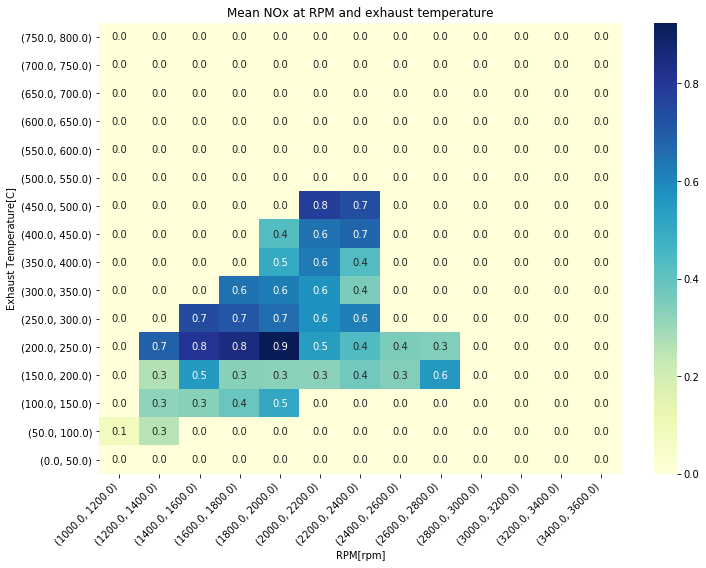

In [11]:
binplotNOx = heatMap(df.cps_n_engine, df.egr_T_exhaust_temperature, 
                          df.NOx, rpmbins, exhTbins, 
                          title = "Mean NOx at RPM and exhaust temperature", 
                          method = "mean", scatterXlabel = "RPM[rpm]", 
                          scatterYlabel = "Exhaust Temperature[C]", 
                          cmap = "YlGnBu")

# Total NOx Binplot

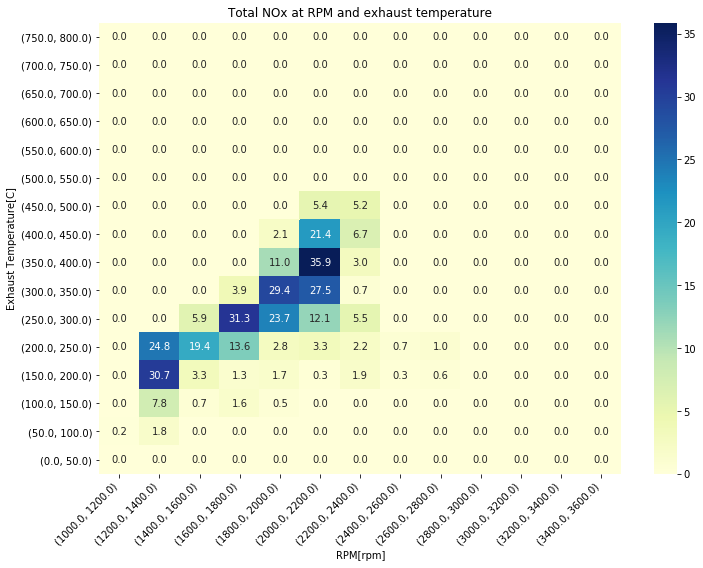

In [12]:
binplotNOx = heatMap(df.cps_n_engine, df.egr_T_exhaust_temperature, 
                          df.NOx, rpmbins, exhTbins, 
                          title = "Total NOx at RPM and exhaust temperature", 
                          method = "sum", scatterXlabel = "RPM[rpm]", 
                          scatterYlabel = "Exhaust Temperature[C]", 
                          cmap = "YlGnBu")

# Percentage time @ each operating point

100.0


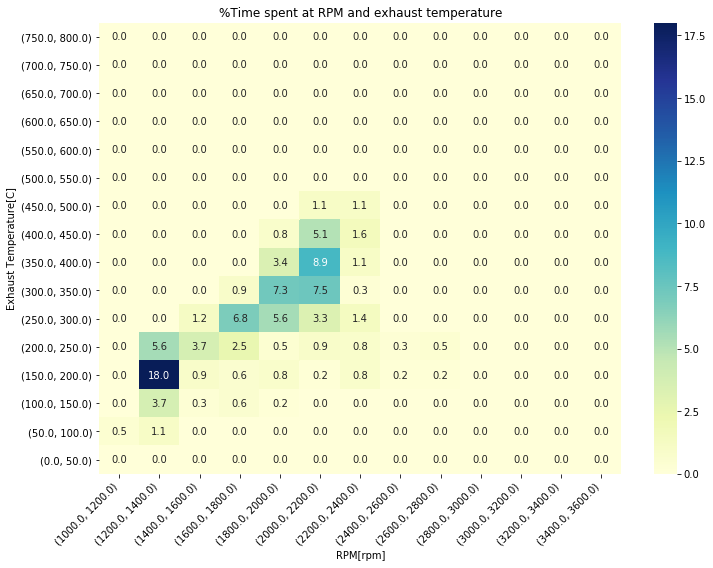

In [13]:
binplotTime = heatMap(df.cps_n_engine, df.egr_T_exhaust_temperature, 
                             df.egr_P_exhaustp, rpmbins, exhTbins, 
                             title = "%Time spent at RPM and exhaust temperature", 
                             method = "count", scatterXlabel = "RPM[rpm]", 
                             scatterYlabel = "Exhaust Temperature[C]", 
                             cmap = "YlGnBu")

# NOx Modal

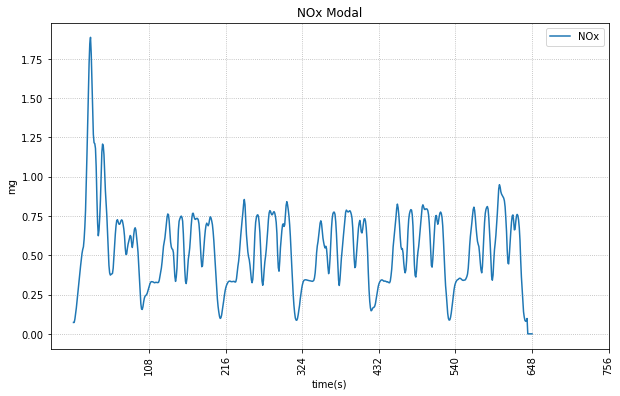

In [14]:
graph(df['NOx'])

# CO Modal

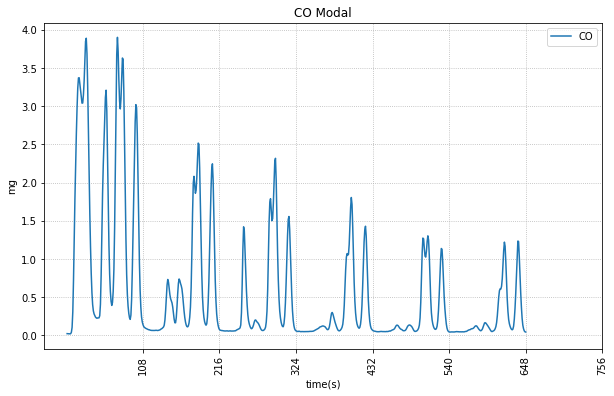

In [15]:
graph(df['CO'])

# THC Modal

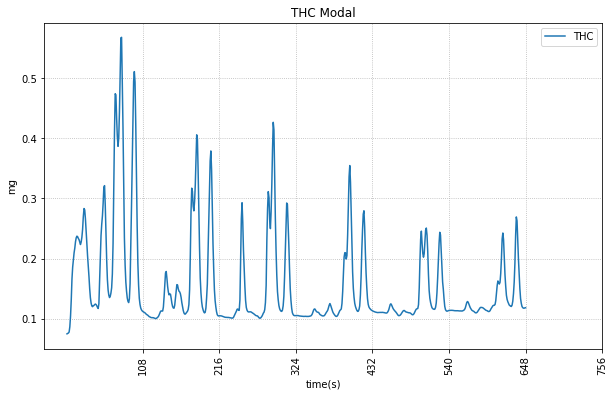

In [16]:
graph(df['THC'])